In [16]:
%matplotlib inline
import numpy as np
import numpy.random as npr

def generate_expression_data(n_analytes=100, n_samples=2, n_replicates=3, p_regulated=0.2, mean_offset=3.0, var=0.2, diff_var=2.0):

    labels = npr.binomial(1, p_regulated, (n_analytes,n_samples-1))
    template = np.hstack((np.zeros((n_analytes,1)),labels))
    regulated = np.repeat(template,n_replicates, axis=1)
    diff = regulated*npr.normal(0,diff_var,(n_analytes,1))
    offset = np.ones((n_analytes,n_samples*n_replicates))*npr.normal(mean_offset,mean_offset,(n_analytes,1))
    expression = npr.normal(offset+diff,var,(n_analytes,n_replicates*n_samples))
    expression = 2**expression
    
    v = np.ones((n_analytes,1))
    sample_number = np.repeat(np.hstack([v*ix for ix in range(1,n_samples+1)]), n_replicates, axis=1)
        
        
    return expression,labels,sample_number


In [17]:
def bootstrap(invec):
    idx = npr.randint(0, len(invec), len(invec))
    return [invec[i] for i in idx]

def estimatePi0(p, numBoot=100, numLambda=100, maxLambda=0.95):
    p.sort()
    n=len(p)
    lambdas=np.linspace(maxLambda/numLambda,maxLambda,numLambda)
    Wls=np.array([n-np.argmax(p>=l) for l in lambdas])
    pi0s=np.array([Wls[i] / (n * (1 - lambdas[i])) for i in range(numLambda)])
    minPi0=np.min(pi0s)
    mse = np.zeros(numLambda)
    for boot in range(numBoot):
        pBoot = bootstrap(p)
        pBoot.sort()
        WlsBoot =np.array([n-np.argmax(pBoot>=l) for l in lambdas])
        pi0sBoot =np.array([WlsBoot[i] / (n *(1 - lambdas[i])) for i in range(numLambda)])
        mse = mse + np.square(pi0sBoot-minPi0)
    minIx = np.argmin(mse)
    return pi0s[minIx]

def qvalues(pvalues):
    m=len(pvalues)
    pvalues.sort()
    pi0 = estimatePi0([p for p,coord in pvalues])
    num_p, p_sum, qs = 0.0, 0.0, []
    for p,coord in pvalues:
        num_p += 1.0
        p_sum += p
        q = pi0*p*m/num_p
        qs.append((q,p,coord))
    qs.reverse()
    old_q=1.0
    for ix in range(len(qs)):
        q = min(old_q,qs[ix][0])
        old_q = q
        qs[ix] = (q,qs[ix][1],qs[ix][2])
    qs.reverse()
    return qs

In [18]:
expression,labels,sample_number = generate_expression_data(10000)

from scipy.stats import ttest_ind
my_shape = (expression.shape[0],-1)
a = expression[sample_number==1].reshape(my_shape)
b = expression[sample_number==2].reshape(my_shape)
_, pvalue_array = ttest_ind(np.log(a), np.log(b), axis=1, equal_var=True)

pv = zip(list(pvalue_array),range(expression.shape[0]))
qv = qvalues(pv)

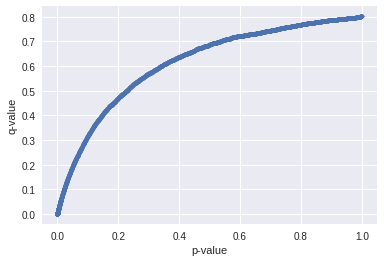

In [19]:
import matplotlib.pyplot as plt
plt.plot([q[1] for q in qv],[q[0] for q in qv],'b.')
plt.xlabel("p-value")
plt.ylabel("q-value")
plt.show()

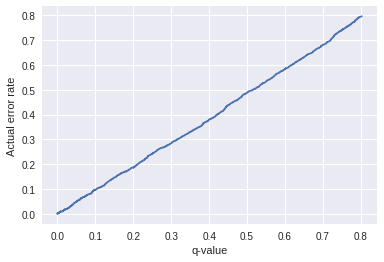

In [20]:
number_of_errors,number_stat_above_threshold = 0.0,0.0
error_rates,ixs = [],[q[2] for q in qv]
for is_regulated in (labels[ixs]):
    number_of_errors += (1.0-is_regulated)
    number_stat_above_threshold += 1.0 
    error_rates.append(number_of_errors/number_stat_above_threshold)
plt.plot([q[0] for q in qv],error_rates,'b-')
plt.xlabel("q-value")
plt.ylabel("Actual error rate")
plt.show()

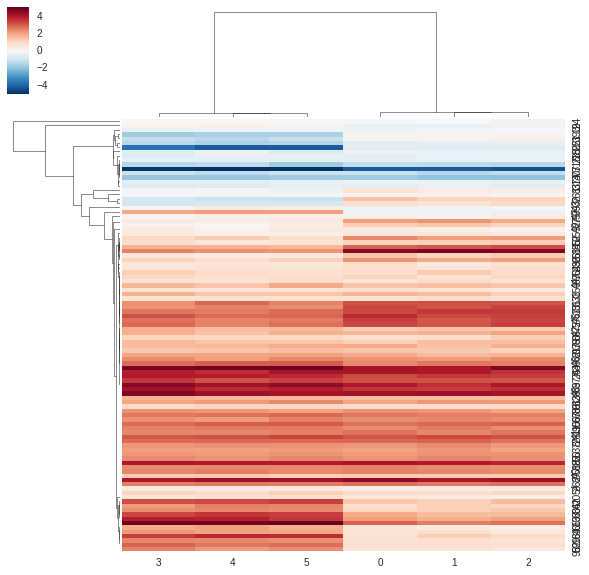

In [29]:
import pandas as pd

expression,labels,sample_number = generate_expression_data(100,mean_offset=2.0,p_regulated=0.5)
df = pd.DataFrame(np.log(expression))
import seaborn as sns; sns.set(color_codes=True)
g = sns.clustermap(df,metric="cosine",method='single')
